In [51]:
import numpy as np
import os
import pandas as pd
import ast

### Extracting data

In [62]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)


In [63]:
def parse_xsf(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    atomic_positions = []
    forces = []
    energy = None

    # Parse the file line by line
    for i, line in enumerate(lines):
        if "PRIMCOORD" in line:
            # Read the number of atoms
            num_atoms = int(lines[i + 1].split()[0])
            # Read atomic positions and forces
            for j in range(num_atoms):
                atom_data = lines[i + 2 + j].split()
                # print(atom_data)
                atomic_positions.append([atom_data[0], float(atom_data[1]), float(atom_data[2]), float(atom_data[3])])
                forces.append([float(atom_data[4]), float(atom_data[5]), float(atom_data[6])])
        if "energy" in line.lower():
            # Extract energy (assuming the line contains "energy = <value>")
            energy = float(line.split()[-2])

    return np.array(atomic_positions), np.array(forces), energy

# Step 2: Load all XSF files and extract data
def load_xsf_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".xsf"):
            file_path = os.path.join(directory, filename)
            atomic_positions, forces, energy = parse_xsf(file_path)
            if energy is not None:  # Only include files with valid energy values
                data.append({
                    'atomic_positions': atomic_positions,
                    'forces': forces,
                    'energy': energy
                })
    return pd.DataFrame(data)

In [64]:
xsf_directory = "data-set-2016-TiO2"  # Replace with the path to your XSF files
df = load_xsf_files(xsf_directory)

In [ ]:
#this is being done because the file contains "Ti" and "O" as strings, we need to convert them to 1 and 0
def convert_atomic_positions(positions):
    converted_positions = []
    for row in positions:
        atom_type = 1.0 if row[0] == "Ti" else 0.0  # Replace Ti with 1, O with 0
        coordinates = list(map(float, row[1:]))  # Convert coordinates to float
        converted_positions.append([atom_type] + coordinates)
    return np.array(converted_positions)

df['atomic_positions'] = df['atomic_positions'].apply(convert_atomic_positions)

### Feature Extraction Functions for TiO2 Potential Energy Prediction

#### 1. `compute_coordination`
- **Purpose**: Computes the coordination number (average number of neighbors) for atoms of a specified element within a cutoff distance.
- **Inputs**:
  - `positions`: List of atomic positions.
  - `element`: Element type (`1.0` for Ti, `0.0` for O).
  - `cutoff`: Maximum distance to consider neighboring atoms.
- **Output**: Mean coordination number.

---

#### 2. `force_features`
- **Purpose**: Extracts statistical features from force vectors acting on atoms.
- **Inputs**:
  - `forces`: List of force vectors for each atom.
- **Output**: Dictionary containing:
  - `mean_force`, `mean_x_force`, `mean_y_force`, and `mean_z_force`.

---

#### 3. `extract_cell_features`
- **Purpose**: Extracts geometric and physical features related to the unit cell.
- **Inputs**:
  - `positions`: List of atomic positions.
- **Output**: Dictionary containing:
  - `volume`: Volume of the bounding box.
  - `density`: Atom density within the cell.
  - `avg_dist_from_com`: Average distance from the center of mass.
  - Moments of inertia (`I_xx`, `I_yy`, `I_zz`).

---

#### 4. `atom_type_counts`
- **Purpose**: Counts the number of atoms of each type and calculates their ratio (e.g., Ti/O ratio).
- **Inputs**:
  - `positions`: List of atomic positions.
- **Output**: Dictionary containing:
  - Count of each atom type (`count_Ti`, `count_O`).
  - Ratio (`Ti_O_ratio`).

---

#### 5. `bond_distance_features`
- **Purpose**: Calculates statistics about bond distances between different atom types (e.g., Ti-O and Ti-Ti distances).
- **Inputs**:
  - `positions`: List of atomic positions.
- **Output**: Dictionary containing:
  - Mean bond distances (`mean_Ti_O_dist`, `mean_Ti_Ti_dist`).

---

#### 6. `compute_coulomb_matrix`
- **Purpose**: Computes Coulomb matrix eigenvalues to capture electronic interactions between atoms based on their distances and atomic numbers.
- **Inputs**:
  - `positions`: List of atomic positions.
- **Output**: Dictionary containing:
  - Maximum, minimum, and standard deviation of Coulomb matrix eigenvalues (`coulomb_eigen_max`, `coulomb_eigen_min`, `coulomb_eigen_std`).

---

#### 7. `extract_features`
- **Purpose**: Combines multiple feature extraction functions to generate a comprehensive set of features for machine learning models.
- **Inputs**:
  - DataFrame (`df`) with columns:
    - `atomic_positions`: Atomic positions for each configuration.
    - `forces`: Force vectors for each configuration.
- **Output**: DataFrame containing features such as:
  - Coordination numbers (`ti_coord_mean`, `o_coord_mean`).
  - Force features (`mean_force`, etc.).
  - Cell features (`volume`, etc.).
  - Atom type counts (`count_Ti`, etc.).
  - Bond distance features (`mean_Ti_O_dist`, etc.).
  - Coulomb matrix eigenvalues.

---


In [ ]:
def compute_coordination(positions, element, cutoff=3.5): #computes coordination number
    # Extract coordinates and elements
    elements = [pos[0] for pos in positions]
    coords = [np.array(pos[1:]) for pos in positions]
    
    # Find indices of specified element
    element_indices = [i for i, e in enumerate(elements) if e == element]
    
    # Calculate coordination numbers
    coordination = []
    for idx in element_indices:
        neighbors = 0
        for j, e in enumerate(elements):
            if j != idx and e != element:
                dist = np.linalg.norm(np.array(coords[idx]) - np.array(coords[j]))
                if dist < cutoff:
                    neighbors += 1
        coordination.append(neighbors)
    
    if coordination:
        return np.mean(coordination)
    else:
        return 0

def force_features(forces): #extracts statistical features from forces
    # Calculate force magnitudes
    magnitudes = np.array([np.linalg.norm(force) for force in forces])
    
    # Extract force components
    x_forces = np.array([f[0] for f in forces])
    y_forces = np.array([f[1] for f in forces])
    z_forces = np.array([f[2] for f in forces])
    
    # Calculate statistical features
    features = {
        'mean_force': np.mean(magnitudes),
        
        'mean_x_force': np.mean(x_forces),
        'mean_y_force': np.mean(y_forces),
        'mean_z_force': np.mean(z_forces),}
    
    return features

def extract_cell_features(positions): #extracts features from the cell such as volume, density, center of mass, moments of inertia
    # Extract coordinates
    coords = np.array([pos[1:] for pos in positions])
    
    # Calculate bounding box dimensions
    x_min, y_min, z_min = np.min(coords, axis=0)
    x_max, y_max, z_max = np.max(coords, axis=0)
    
    # Cell dimensions
    cell_dims = [x_max - x_min, y_max - y_min, z_max - z_min]
    
    # Cell volume
    volume = np.prod(cell_dims)
    
    # Density (number of atoms per volume)
    density = len(positions) / volume if volume > 0 else 0
    
    # Calculate center of mass
    com = np.mean(coords, axis=0)
    
    # Calculate average distance from center of mass
    avg_dist_from_com = np.mean([np.linalg.norm(coord - com) for coord in coords])
    
    # Calculate moments of inertia
    I_xx = np.sum([(y - com[1])**2 + (z - com[2])**2 for x, y, z in coords])
    I_yy = np.sum([(x - com[0])**2 + (z - com[2])**2 for x, y, z in coords])
    I_zz = np.sum([(x - com[0])**2 + (y - com[1])**2 for x, y, z in coords])
    
    return {
        'volume': volume,
        'density': density,
        'avg_dist_from_com': avg_dist_from_com,
        'I_xx': I_xx,
        'I_yy': I_yy,
        'I_zz': I_zz,
    }

def atom_type_counts(positions): #extracts the number of atoms of each type
    elements = [pos[0] for pos in positions]
    unique_elements = set(elements)
    
    counts = {}
    for element in unique_elements:
        counts[f'count_{element}'] = elements.count(element)
    
    # Add ratio features
    if 1.0 in counts and 0.0 in counts:
        if counts['count_O'] > 0:
            counts['Ti_O_ratio'] = counts['count_Ti'] / counts['count_O']
        else:
            counts['Ti_O_ratio'] = 0
    
    return counts

def bond_distance_features(positions): # extracts statistics about bond distances between different atom types
    # Extract elements and coordinates
    elements = [pos[0] for pos in positions]
    coords = [np.array(pos[1:]) for pos in positions]
    
    # Find indices for Ti and O atoms
    ti_indices = [i for i, e in enumerate(elements) if e == 1.0]
    o_indices = [i for i, e in enumerate(elements) if e == 0.0]
    
    # Calculate Ti-O distances
    ti_o_distances = []
    for ti_idx in ti_indices:
        for o_idx in o_indices:
            dist = np.linalg.norm(coords[ti_idx] - coords[o_idx])
            if dist < 1.9:  # Cutoff for reasonable bond distance
                ti_o_distances.append(dist)
    
    # Calculate Ti-Ti distances
    ti_ti_distances = []
    for i in range(len(ti_indices)):
        for j in range(i+1, len(ti_indices)):
            dist = np.linalg.norm(coords[ti_indices[i]] - coords[ti_indices[j]])
            if dist < 3.5:  # Cutoff for reasonable Ti-Ti distance
                ti_ti_distances.append(dist)
    
    # Calculate statistics
    features = {}
    
    # Ti-O bond statistics
    if ti_o_distances:
        features['mean_Ti_O_dist'] = np.mean(ti_o_distances)
    else:
        features['mean_Ti_O_dist'] = 0
    
    # Ti-Ti distance statistics
    if ti_ti_distances:
        features['mean_Ti_Ti_dist'] = np.mean(ti_ti_distances)
    else:
        features['mean_Ti_Ti_dist'] = 0
    
    return features

def compute_coulomb_matrix(positions): # extracts eigenvalues of the Coulomb matrix to describe about the electronic interactions
    # Atomic numbers (Ti=22, O=8)
    atomic_numbers = [22 if pos[0] == 'Ti' else 8 for pos in positions]
    coords = [np.array(pos[1:]) for pos in positions]
    
    n_atoms = len(positions)
    coulomb_matrix = np.zeros((n_atoms, n_atoms))
    
    for i in range(n_atoms):
        for j in range(n_atoms):
            if i == j:
                coulomb_matrix[i, j] = 0.5 * atomic_numbers[i]**2.4
            else:
                dist = np.linalg.norm(coords[i] - coords[j])
                coulomb_matrix[i, j] = atomic_numbers[i] * atomic_numbers[j] / dist
    
    eigenvalues = np.linalg.eigvals(coulomb_matrix)
    
    return {
        'coulomb_eigen_max': np.max(eigenvalues),
        'coulomb_eigen_min': np.min(eigenvalues),
        'coulomb_eigen_std': np.std(eigenvalues),

    }

def extract_features(df):
    features_list = []
    
    for idx, row in df.iterrows():
        positions = row['atomic_positions']
        forces = row['forces']
        
        # Extract features
        features = {}
        
        # Coordination features
        ti_coord_mean = compute_coordination(positions, 1.0, cutoff=3.0)
        o_coord_mean = compute_coordination(positions, 0.0, cutoff=3.0)
        
        features['ti_coord_mean'] = ti_coord_mean
        features['o_coord_mean'] = o_coord_mean
        
        # Force features
        force_feats = force_features(forces)
        features.update(force_feats)
        
        # Cell features
        cell_feats = extract_cell_features(positions)
        features.update(cell_feats)
        
        # Atom type counts
        atom_counts = atom_type_counts(positions)
        features.update(atom_counts)
        
        # Bond distance features
        bond_feats = bond_distance_features(positions)
        features.update(bond_feats)
        
        # Coulomb matrix eigenvalues
        coulomb_feats = compute_coulomb_matrix(positions)
        features.update(coulomb_feats)
        
        features_list.append(features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    
    return features_df

In [82]:
feature_db = extract_features(df)
feature_db

,ti_coord_mean,o_coord_mean,mean_force,mean_x_force,mean_y_force,mean_z_force,volume,density,avg_dist_from_com,I_xx,I_yy,I_zz,count_0.0,count_1.0,mean_Ti_O_dist,mean_Ti_Ti_dist,coulomb_eigen_max,coulomb_eigen_min,coulomb_eigen_std
0,3.250,1.733333,1.194343,-1.173913e-08,1.086957e-08,-1.086957e-08,156.224487,0.147224,3.309677,179.017062,138.915198,244.093865,15,8,1.887402,3.127567,429.197593,26.940921,81.485896
1,3.000,1.500000,0.641969,0.000000e+00,0.000000e+00,0.000000e+00,19.257582,0.311566,2.013195,19.597730,24.241699,9.475984,4,2,0.000000,0.000000,187.039559,34.015748,52.164217
2,3.125,1.785714,2.460871,9.090909e-10,2.272727e-08,-1.136364e-08,223.343893,0.098503,3.332813,206.760402,104.326720,231.194141,14,8,1.791397,3.153750,419.275526,27.233569,81.199832
3,2.000,1.000000,0.540596,0.000000e+00,0.000000e+00,0.000000e+00,28.998880,0.206905,2.357111,27.493790,17.143292,22.771131,4,2,0.000000,0.000000,174.749477,38.277999,47.783386
4,3.500,1.750000,2.481709,-4.166666e-10,8.333333e-10,2.041667e-08,169.515673,0.141580,3.299581,181.170511,150.732751,246.770572,16,8,1.863547,3.099589,444.866656,26.369377,83.083625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7810,2.875,1.642857,1.836999,2.363636e-08,-1.181818e-08,-2.318182e-08,219.633513,0.100167,3.277284,159.422217,143.614099,231.656854,14,8,1.755082,3.081426,416.372480,25.980161,79.788063
7811,3.500,1.750000,2.451944,-2.041667e-08,4.166667e-10,-1.125000e-08,182.876379,0.131236,3.353370,188.813857,153.501587,258.342983,16,8,1.865309,3.091387,440.447618,26.487566,82.190681
7812,3.500,1.750000,1.486259,0.000000e+00,0.000000e+00,0.000000e+00,323.492932,0.074190,3.731813,300.189395,304.947500,148.247013,16,8,0.000000,3.235673,408.815540,31.386429,75.137262
7813,2.000,1.000000,1.831555,0.000000e+00,0.000000e+00,0.000000e+00,16.970671,0.353551,1.971603,19.235927,11.994240,15.931736,4,2,1.743599,0.000000,194.543596,31.387752,57.126506


### Gradient Boosting Regression

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_scaled = StandardScaler().fit_transform(feature_db)
y = df['energy']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.4, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


MSE: 14299.5362
RMSE: 119.5807
MAE: 3.2183
R²: 0.9998


### Neural Network

Epoch 1/100


/Users/akshatkumar/Documents/CH5650 - Molecular DS/Assignment 5/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17832.5312 - val_loss: 18297.1699
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 17478.1875 - val_loss: 17351.2051
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16162.4385 - val_loss: 14047.8477
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 11973.8271 - val_loss: 6980.4453
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 6001.3989 - val_loss: 4418.9766
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3882.7437 - val_loss: 3096.8477
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 3048.0024 - val_loss: 2130.3691
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 2340.2107 - val_loss: 1640.9216
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 2009.0530 - val_loss: 1445.0624
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1870.9760 - val_loss: 1302.1849
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1805.5331 - val_

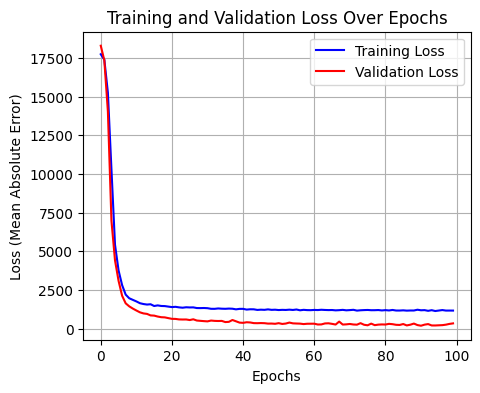

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),  # Ensure input shape matches scaled features
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model with mean absolute error (MAE) loss for negative y values
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.3)

# Extract training history
history_dict = history.history

# Plot training and validation loss over epochs
plt.figure(figsize=(5, 4))
plt.plot(history_dict['loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [104]:
predictions = model.predict(X_test)

# Calculate R² value
r2 = r2_score(y_test, predictions)
print(f"R² Value: {r2:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
R² Value: 0.9979


## Results

| Model   | R2 Value |
|---------|----------|
| Gradient Boosting Regression | 0.999   |
| Physics Based Neural Network | 0.997   |
